In [71]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

In [72]:
#environnement Frozen Lake -- mettre v0 ou v1 suivant votre version
env_fl = gym.make('FrozenLake-v1')

## Environnement maison : exemple du personnage
On reprend l'API de gym avec les méthodes reset et step

In [74]:
class Personnage_Env:
    """environnement type API gym représentant l'exemple du cours"""
    
    def __init__(self, R):
        """
        R : paramètre de récompense de l'action 1:Récolter dans l'état 1:Affamé
        """
        
        self.observation_space = gym.spaces.Discrete(3) # 0 :OK, 1 :Affamé, 2:Mort
        self.action_space = gym.spaces.Discrete(2)      # 0 : Manger 1 : Récolter
        self.P = {0: {0 : [(0.8, 0, 1.0, False),
                          (0.2, 1, 1.0, False )],
                     1 : [(0.5, 0, 10.0, False),
                         (0.5, 1, 10.0, False)]},
                 1 : {0: [(0.5, 0, 0.0, False),
                         (0.25, 1, 0.0, False),
                         (0.25, 2, 0.0, True)],
                     1 : [(0.5, 1, R, False),
                         (0.5, 2, R, True)]},
                 2 : {0 : [(1.0, 2, 0.0, True)],
                     1 : [(1.0, 2, 0.0, True)]}}
        self.reset()
        
    def reset(self):
        self.current_state = 0
        return self.current_state
        
    def step(self, action):
        transitions = self.P[self.current_state][action]
        
        #indices des actions possibles
        choices = list(range(len(transitions)))
        
        # probas correspondantes
        probas = [t[0] for t in transitions]
        
        #choisit i dans choices suivant la proba 
        i = np.random.choice(choices, 1, p=probas)[0]
        
        #mise à jour
        self.current_state = transitions[i][1]
        return transitions[i][1], transitions[i][2], transitions[i][3],  None

In [75]:
env_p = Personnage_Env( R = 5.0)

## Evaluation de la politique aléatoire uniforme

In [89]:
def value_iteration_uniform_policy(env, nb_iter, gamma = 1.0, log = None):
    """
    iteration de valeurs sur les états pour évaluer la politique uniforme
    """
    log_list = []
    states = list(range(env.observation_space.n))
    actions = list(range(env.action_space.n))
    nba = len(actions)

    state_values = defaultdict(lambda :0.0)
    
    for t in range(nb_iter):
        for s0 in states:
            # pour s0 état et a0 action : env.P[s0][a0] est une liste de transitions t
            # t[0] est la proba d'aller vers un état t[1] avec un reward t[2]
            state_values[s0] = sum([ sum([ t[0]/ nba * (t[2] + gamma*state_values[t[1]]) for t in env.P[s0][a0]])   for a0 in env.P[s0] ])
        if log and t%100==0:
            log_list.append(log(state_values))       
    return state_values, log_list

Evaluation de la politique uniforme pour Personnage et FrozenLake (on peut considérer que ces valeurs sont les vraies valeurs)

In [90]:
true_val_p, logs_iteration = value_iteration_uniform_policy(env_p, 10000) ; true_val_p

defaultdict(<function __main__.value_iteration_uniform_policy.<locals>.<lambda>()>,
            {0: 32.85714285714285, 1: 17.14285714285714, 2: 0.0})

In [82]:
#fonction qui calcule l'écart quadratique aux vraies valeurs
err_quad = lambda sv : sum([(sv[s] - true_val_p[s])**2 for s in true_val_p])

In [93]:
true_val_p, logs_iteration = value_iteration_uniform_policy(env_p, 10000, log = err_quad) ; true_val_p

defaultdict(<function __main__.value_iteration_uniform_policy.<locals>.<lambda>()>,
            {0: 32.85714285714285, 1: 17.14285714285714, 2: 0.0})

## Evaluation politique uniforme par Monte Carlo

In [77]:
def MC_uniform_policy(env, nb_iter, alpha, gamma, log = None):
    """
    env : environnement type gym
    nb_iter : nbre épisodes
    alpha : fonction donnant le pas d'apprentissage sur un episode
    gamma : discount du MDP
    """
    log_list = []
    
    #valeurs des états
    state_values = defaultdict(lambda :0.0)
    
    for t in range(nb_iter):
        #debut d'episode
        current_state = env.reset()
        done = False
        etats_vus = [current_state]
        rewards_vus = []
        while not done:
            current_state, reward, done, info = env.step(env.action_space.sample())
            etats_vus.append(current_state)
            rewards_vus.append(reward)
        #print(etats_vus, rewards_vus)
        #mise a jour des valeurs par calcul des gains dans l'épisode
        G = 0
        for i in range(len(etats_vus)-2,-1,-1):
            s = etats_vus[i]
            r = rewards_vus[i]
            G = r + gamma*G
            
            state_values[s] += alpha(t) * (G - state_values[s])
            #print('t=',t,'s=',s,'r=',r,'G=',G,'val=',state_values[s])
          
        if log and t%100==0:
            log_list.append(log(state_values))

    return state_values, log_list
    
    

In [83]:
alpha_h = lambda t : 1/(t+1)
val_mc_p, logs_mc_p = MC_uniform_policy(env_p, 10000, alpha_h, 1.0, log = err_quad)

## Evaluation politique uniforme par TD(0)-Learning

In [79]:
def TD_uniform_policy(env, nb_iter, alpha, gamma, log = None):
    
    state_values = defaultdict(lambda :0.0)
    log_list = [log(state_values)]
    
    for t in range(nb_iter):
        #debut d'episode
        current_state = env.reset()
        done = False
        while not done:
            new_state, reward, done, info = env.step(env.action_space.sample())
            state_values[current_state] += alpha(t)*(reward + gamma*state_values[new_state] - state_values[current_state])
            current_state = new_state
        if log and t%100==0:
            log_list.append(log(state_values))
    return state_values, log_list

In [84]:
#alpha = lambda t : min(1,100/(t+1))
alpha = lambda t : 1/ ((t+1)**0.85)
val_td_p, logs_td_p = TD_uniform_policy(env_p, 10000, alpha, 1.0, log = err_quad)

## Comparaison des algorithmes sur Personnage

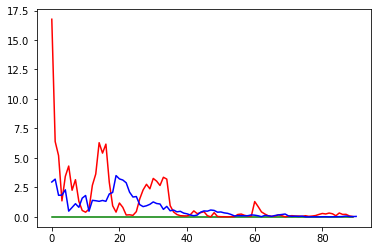

In [95]:
plt.plot(logs_iteration[10:], c='green')
plt.plot(logs_mc_p[10:], c='red')
plt.plot(logs_td_p[10:], c='blue')
plt.show()